In [8]:
#Importing required libraries 
library(twitteR)
library(RSQLite)
library(ggplot2)
library(ggmap)
library(maptools)
library(maps)
library(plyr)


Attaching package: ‘plyr’

The following object is masked from ‘package:maps’:

    ozone

The following object is masked from ‘package:twitteR’:

    id



In [2]:
#Setup for the application (Database and Twitter Oath)
setup_twitter_oauth("yiYmkK3D1Lkce9KH37Q8RQXdz", "VLNYdjRXNQ3Tp6Mo5k7YEA9x8NPHdtADIRRM8DhM6Xv8Sx8quz", "1605909084-OcgJIf5nid4Axf6QZSbPGKIhQMyWwm9v73DjxXC", "OK1I2aSsjvbjP1erIAw4a3hB9B6el9YdKoA5XYZ6zXXya")
db <- dbConnect(SQLite(), dbname="tweets.sqlite")
register_sqlite_backend("tweets.sqlite")

[1] "Using direct authentication"


### Change the Twitter Search Term in the cell below this to anything to get the required Tweets

In [3]:
#Twitter Search Term for collecting Tweets 
searchTerm <- "#GoPats #Superbowl"

In [ ]:
#Fetching Tweets and Storing them in Database
tweets <- searchTwitter(searchString = searchTerm, n = 1000)
store_tweets_db(tweets)

In [4]:
#Query the Database to fetch the distinct screen names for all the collected tweets
result <- dbGetQuery(conn = db, statement = "SELECT Distinct(screenName) from tweets")
paste("There are",length(result$screenName),"distinct users in the database", sep=" ")

[1] "There are 9361 distinct users in the database"

In [ ]:
#Fetching user information from Twitter with sleeping for 15 mins after 800 users fetched
#to handle DataLimit for the Twitter API
count = 0
for(i in result$screenName){
    try(store_users_db(lookupUsers(i, includeNA = TRUE)))
    count = count + 1
    if(count==800){
        Sys.sleep(60*15)
        count = 0
    }
}

In [5]:
#Query the database to get all users from the database where location is not empty
result_users <- dbGetQuery(db, "Select * from users where location <> ''")
location_arr <- c(result_users$location)

In [ ]:
#Get the Coordinates in the form of Latitude and Longitude for all the user locations and save them to the database
options(warn = -1) # Supressing the warnings being shown when fetching locations to get better browser performance
for(i in 1:length(locations_arr)){
    #Using the Data Science Toolkit as the source instead of Google Maps API to tackle the API limit that Google 
    #imposes per day.
    try(fetched_locations <- geocode(location_arr[i], source = "dsk"))
    dbWriteTable(db, name="locations", value = fetched_locations, append = TRUE)
}

# Plotting the User Location Map for the United States of America
### A plot for all the distinct users in the collected tweets, grouping the users by their location

In [41]:
#Fetching the Locations saved in the Database and calculating the occurances of all these coordinates to plot 
#a comparable blot on the map of the USA
locations <- dbReadTable(db, "locations")
locations <- count(df = locations, vars = c("lon", "lat"))

# Map of users tweeting about the selected Topic
Used the cex parameter in R to provide the frequency, but when the value of the frequency is very high, the plot looks really cluttered. That is why for every count, the number was reduced by taking the cube root of the value to make it cleaner to plot.
* References: http://www.statmethods.net/advgraphs/parameters.html

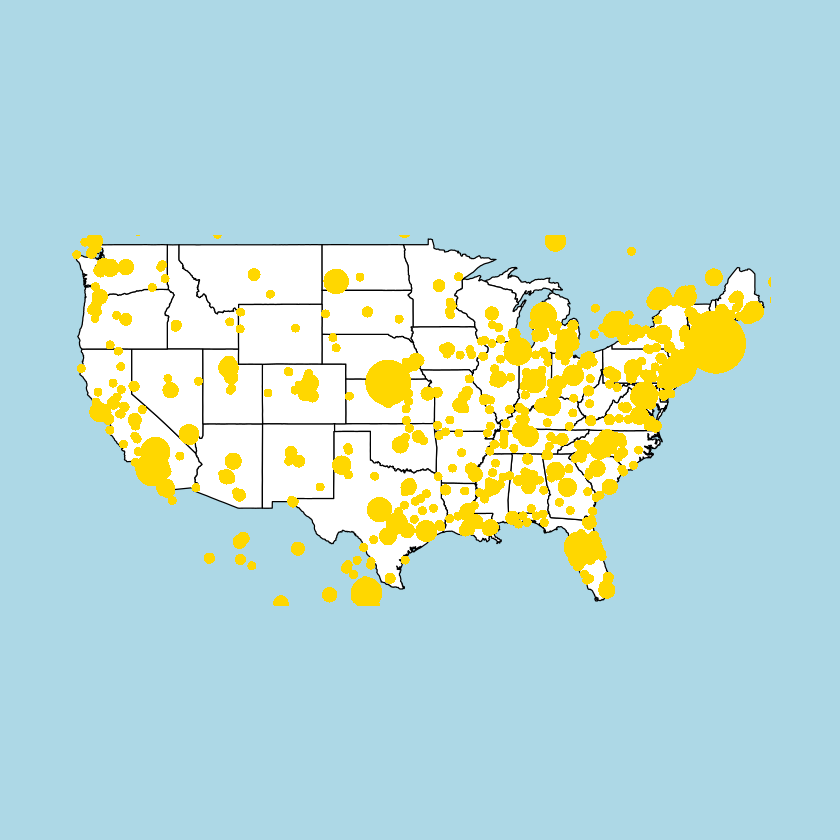

In [42]:
map("state", fill=TRUE, col="white", bg="lightblue")
points(locations$lon,locations$lat, col="gold", pch=16, cex=(locations$freq^(1/3)))